In [1]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import json
import os

import sys
sys.path.append('/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/code')
from dn_utils.behavioral_models_REF import load_behavioral_data

In [2]:
beh_path = "/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/" \
           "data/main_fmri_study/sourcedata/behavioral" 
beh, meta = load_behavioral_data(root=beh_path)
n_subjects = beh.shape[0]
n_conditions = beh.shape[1]
n_trials = beh.shape[2]

Shape of beh array: (32, 2, 110, 23)
Conditions [(0, 'rew'), (1, 'pun')]
Columns: [(0, 'block'), (1, 'block_bci'), (2, 'side'), (3, 'side_bci'), (4, 'magn_left'), (5, 'magn_right'), (6, 'response'), (7, 'rt'), (8, 'won_bool'), (9, 'won_magn'), (10, 'acc_after_trial'), (11, 'onset_iti'), (12, 'onset_iti_plan'), (13, 'onset_iti_glob'), (14, 'onset_dec'), (15, 'onset_dec_plan'), (16, 'onset_dec_glob'), (17, 'onset_isi'), (18, 'onset_isi_plan'), (19, 'onset_isi_glob'), (20, 'onset_out'), (21, 'onset_out_plan'), (22, 'onset_out_glob')]


In [ ]:
# <--- TODO: refactor
def generate_responses_pd(beh, meta, subject, condition, 
                         alpha_plus, alpha_minus, beta):
    '''Creates responses from artificial subject using specified parameter 
    values. Note that it uses already existing task data (like trial-wise reward
    magnitudes and correct boxes) but it is independent of the collected 
    behavioral data.
    
    Args:
        beh (np.array): aggrgated behavioral response
        meta (dict): description of beh array coding
        subject (int): subject index
        condition (int): task condition index 
        alpha_plus (float): learning rate for positive PE
        alpha_minus (float): learning rate for negative PE
        beta (float): inverse-temperature parameter
        
    Returns:
        Vector of artificial responses. Values coding left and right simulated 
        button presses are -1 and 1. 
    '''

    n_trials = beh.shape[2]
    wbci, util, magn = (np.zeros((n_trials, 2)) for _ in range(3))
    p, response = (np.zeros((n_trials)) for _ in range(2))
    wbci[0] = [.5, .5] # Initial belefis (agnostic)

    side_bci = np.copy(beh[subject, condition, :, meta['dim4'].index('side_bci')])
    side = np.copy(beh[subject, condition, :, meta['dim4'].index('side')])
    magn[:, 0] = beh[subject, condition, :, meta['dim4'].index('magn_left')]
    magn[:, 1] = beh[subject, condition, :, meta['dim4'].index('magn_right')]

    for t in range(0, n_trials):

        # Calculate expected utility 
        util[t, :] = np.multiply(magn[t, :], wbci[t, :])

        # Pass it into softmax & generate response
        p[t] = np.exp(beta*util[t, 1]) / np.sum(np.exp(beta*util[t, :]))
        response[t] = np.random.choice([-1, 1], p=[1-p[t], p[t]])

        # Use correct learning rate for trial
        alpha = alpha_plus * (side[t] == response[t]) \
              + alpha_minus * (side[t] != response[t])
        
        # Update prbobabilities before next trial (ignore last update)
        if t < n_trials-1: 
            wbci[t+1, 1] = wbci[t, 1] + alpha * ((side_bci[t] + 1)/2 - wbci[t, 1])
            wbci[t+1, 0] = wbci[t, 0] + alpha * ((-side_bci[t] + 1)/2 - wbci[t, 0])

    return response

### Create synthetic responses for different RL parameters
Here, artificial responses are created for different values of possible RL parameters. Task data is pooled from beh matrix (it is not generated from scratch, but reuse existing data). Note that subject behavioral responses **are not used** at all.

In [3]:
grid_alpha_plus = np.arange(0, 1.05, 0.05)
grid_alpha_minus = np.arange(0, 1.05, 0.05)
grid_beta = np.linspace(.05, .15, 3)

n_gridpoints_alpha_plus = len(grid_alpha_plus)
n_gridpoints_alpha_minus = len(grid_alpha_minus)
n_gridpoints_beta = len(grid_beta)

response_synthetic = np.zeros(
    (n_gridpoints_alpha_plus, n_gridpoints_alpha_minus, n_gridpoints_beta,
     n_conditions, n_trials)
)

subjects = [f'm{sub:02}' for sub in range(2, 34)]

In [ ]:
for sub_idx, sub_label in enumerate(subjects):

    # Loop over grid values
    for ix_ap, ap in enumerate(grid_alpha_plus):
        for ix_am, am in enumerate(grid_alpha_minus):
            for ix_bt, bt in enumerate(grid_beta):

                for con in [0, 1]:
                    response_synthetic[ix_ap, ix_am, ix_bt, con, :] = \
                        generate_responses_pd(beh, meta, sub_idx, con, 
                                              ap, am, bt)

    # Save synthetic responses to *.mat format
    scipy.io.savemat(
        f'matjags-dn/data/parameter_recovery/response_synthetic_sub-{sub_label}.mat', 
        {'response_synthetic': response_synthetic}, appendmat=True)

# Analyze Bayesian modeling inference results

### Load JAGS output (parameter recovery analysis) 

In [4]:
jags_path = '/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/' \
            'code/behavioral_analysis/matjags-dn/data/parameter_recovery_inference'

samples_ap = scipy.io.loadmat(os.path.join(jags_path, 'samples_bt_2.mat'))['samples_ap']
samples_am = scipy.io.loadmat(os.path.join(jags_path, 'samples_bt_2.mat'))['samples_am']
samples_bt = scipy.io.loadmat(os.path.join(jags_path, 'samples_bt_2.mat'))['samples_bt']

bt_fixed = 0.1;

### Find posterior maximum to estimate recovered model parameters
1. Use kernel density estimation (KDE) method to "smooth" histogram, and find maximum of the posterior.
2. Use Bayesian Credible Interval to estimate uncertainty of parameter recovery

In [5]:
kernel_width = 0.05                  # Gaussian kernel width
ci_width = .95                       # Credible interval
n_samples = 5000                     # Number of posterior samples
gridpoints = np.linspace(0, 1, 250)  # Possible values of estimated LR's

cimin = (1 - ci_width) / 2
cimax = (1 + ci_width) / 2

ap_recovered = np.zeros((n_gridpoints_alpha_plus, n_gridpoints_alpha_minus))
am_recovered = np.zeros((n_gridpoints_alpha_plus, n_gridpoints_alpha_minus))
bt_recovered = np.zeros((n_gridpoints_alpha_plus, n_gridpoints_alpha_minus))

ap_uncert = np.zeros((n_gridpoints_alpha_plus, n_gridpoints_alpha_minus))
am_uncert = np.zeros((n_gridpoints_alpha_plus, n_gridpoints_alpha_minus))
bt_uncert = np.zeros((n_gridpoints_alpha_plus, n_gridpoints_alpha_minus))

kde = KernelDensity(bandwidth=kernel_width, kernel='gaussian')

for ix_ap, ap in enumerate(grid_alpha_plus):
    for ix_am, am in enumerate(grid_alpha_minus):
        
        # Calculate recovered parameters as maximum likelihood of posterior 
        # distribution and their uncertainty as width of Bayesian credible interval
        samples = samples_ap[ix_ap, ix_am].flatten()[:, np.newaxis]
        kde.fit(samples)
        ap_recovered[ix_ap, ix_am] = gridpoints[np.argmax(kde.score_samples(gridpoints[:, np.newaxis]))]
        ap_uncert[ix_ap, ix_am] = np.sort(samples, axis=0)[int(cimax*n_samples)] \
                                - np.sort(samples, axis=0)[int(cimin*n_samples)]

        samples = samples_am[ix_ap, ix_am].flatten()[:, np.newaxis]
        kde.fit(samples)
        am_recovered[ix_ap, ix_am] = gridpoints[np.argmax(kde.score_samples(gridpoints[:, np.newaxis]))]
        am_uncert[ix_ap, ix_am] = np.sort(samples, axis=0)[int(cimax*n_samples)] \
                                - np.sort(samples, axis=0)[int(cimin*n_samples)]        
        
        samples = samples_bt[ix_ap, ix_am].flatten()[:, np.newaxis]
        kde.fit(samples)
        bt_recovered[ix_ap, ix_am] = gridpoints[np.argmax(kde.score_samples(gridpoints[:, np.newaxis]))]
        bt_uncert[ix_ap, ix_am] = np.sort(samples, axis=0)[int(cimax*n_samples)] \
                                - np.sort(samples, axis=0)[int(cimin*n_samples)]

# Make alpha+ sit on X-axis
ap_recovered = np.swapaxes(ap_recovered, 0, 1)
am_recovered = np.swapaxes(am_recovered, 0, 1)
bt_recovered = np.swapaxes(bt_recovered, 0, 1)
ap_uncert = np.swapaxes(ap_uncert, 0, 1)
am_uncert = np.swapaxes(am_uncert, 0, 1)
bt_uncert = np.swapaxes(bt_uncert, 0, 1)

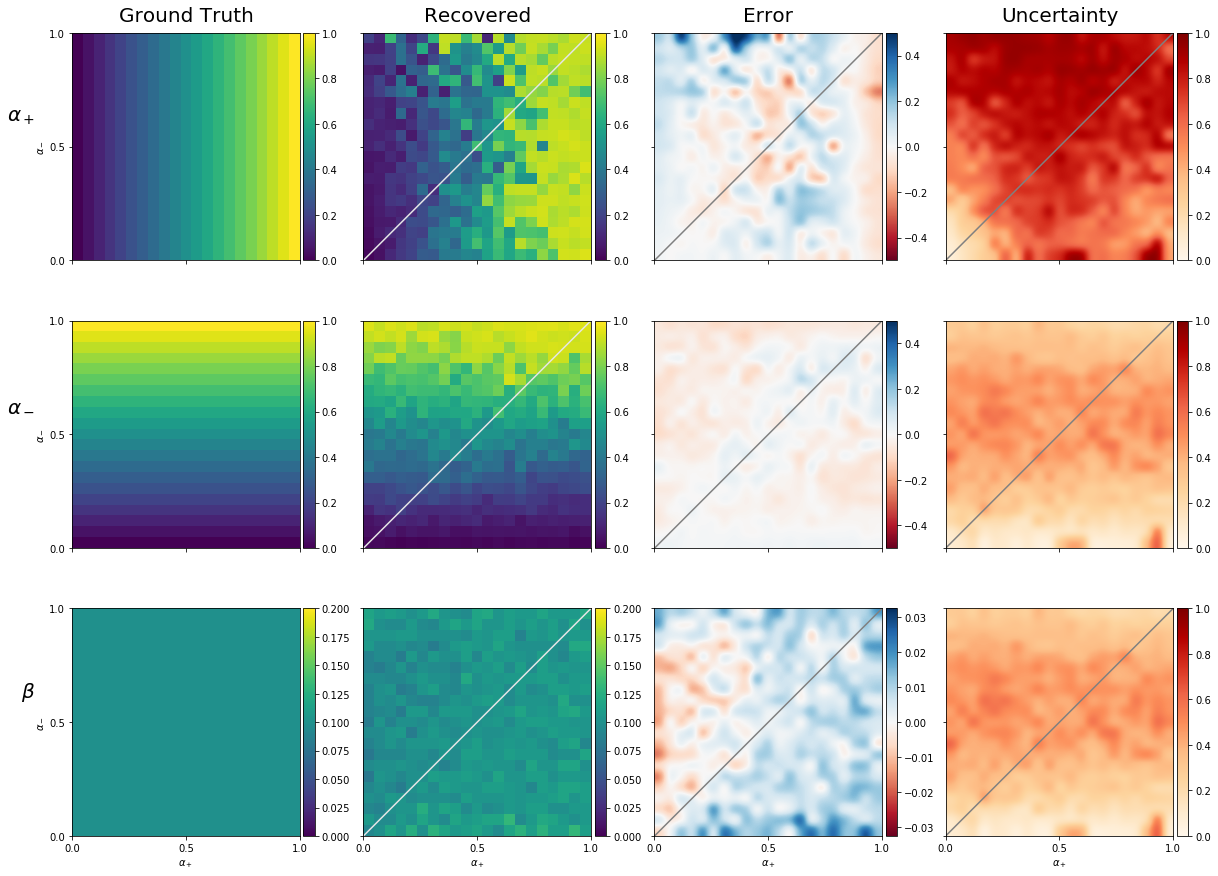

In [6]:
# Generate true parameter values
ap_true, am_true = np.meshgrid(grid_alpha_plus, grid_alpha_minus) # Notice counterintuitive order
bt_true = np.ones((n_gridpoints_alpha_plus, n_gridpoints_alpha_plus)) * bt_fixed;

# Generate plot
fig, ax = plt.subplots(ncols=4, nrows=3, figsize=(20, 15), facecolor='w',
                       sharex=True, sharey=True)

kwargs = {
    'extent': [0, 1, 0, 1],
    'origin': 'lower'
}

cols = ['Ground Truth', 'Recovered', 'Error', 'Uncertainty']
rows = [r'$\alpha_+$', r'$\alpha_-$', r'$\beta$']

im_tru, im_rec, im_dif, im_unc= [], [], [], []
cax_tru, cax_rec, cax_dif, cax_unc = [], [], [], []

for row in range(3):
        
    if row == 0:
        param_tru = ap_true
        param_rec = ap_recovered
        param_unc = ap_uncert
    elif row == 1: 
        param_tru = am_true
        param_rec = am_recovered
        param_unc = am_uncert
    else:
        param_tru = bt_true
        param_rec = bt_recovered
        param_unc = am_uncert
        
    param_dif = param_rec-param_tru

    im_tru.append(ax[row, 0].imshow(param_tru, **kwargs))
    im_rec.append(ax[row, 1].imshow(param_rec, **kwargs))
    im_dif.append(ax[row, 2].imshow(param_dif, **kwargs, cmap='RdBu', interpolation='gaussian'))
    im_unc.append(ax[row, 3].imshow(param_unc, **kwargs, cmap='OrRd', interpolation='gaussian'))
    
    if row in [0, 1]:
        im_tru[row].set_clim([0, 1])
        im_rec[row].set_clim([0, 1])
        im_dif[row].set_clim([-.5, .5])
        im_unc[row].set_clim([0, 1])
    else:
        im_tru[row].set_clim([0, .2])
        im_rec[row].set_clim([0, .2])
        im_dif[row].set_clim([-np.max(np.abs(param_dif)), np.max(np.abs(param_dif))])
        im_unc[row].set_clim([0, 1])

    cax_tru.append(make_axes_locatable(ax[row, 0]).append_axes("right", size="5%", pad=0.05))
    cax_rec.append(make_axes_locatable(ax[row, 1]).append_axes("right", size="5%", pad=0.05))
    cax_dif.append(make_axes_locatable(ax[row, 2]).append_axes("right", size="5%", pad=0.05))
    cax_unc.append(make_axes_locatable(ax[row, 3]).append_axes("right", size="5%", pad=0.05))

    fig.colorbar(im_tru[row], cax=cax_tru[row])
    fig.colorbar(im_rec[row], cax=cax_rec[row])
    fig.colorbar(im_dif[row], cax=cax_dif[row])
    fig.colorbar(im_unc[row], cax=cax_unc[row])

for row in range(3):
    for col in range(4):
        
        if row == 2: 
            ax[row,col].set_xlabel(r'$\alpha_+$')
        if col == 0:
            ax[row,col].set_ylabel(r'$\alpha_-$')
        
        ax[row,col].set_xticks(np.linspace(0, 1, 3))
        ax[row,col].set_yticks(np.linspace(0, 1, 3))
        
        # Plot additional diagonal line
        if col == 1:
            ax[row,col].plot([0, 1], color=(.9, .9, .9))
        if col in [2, 3]:
            ax[row,col].plot([0, 1], color=(.5, .5, .5))
            
# Set row and column titles
for a, col in zip(ax[0], cols):
    a.annotate(col, xy=(0.5, 1.05), xytext=(0, 0), xycoords='axes fraction', 
               textcoords='offset points', size=20, ha='center', va='baseline')

for a, row in zip(ax[:,0], rows):
    a.annotate(row, xy=(0, 0.5), xytext=(0, 30), xycoords=a.yaxis.label, 
               textcoords='offset points', size=20, ha='right', va='center')    